In [7]:
from __future__ import annotations
import math
import random
from dataclasses import dataclass
from typing import Dict, Iterable, List, Optional, Tuple

import pandas as pd

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import BatchSampler
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt



In [8]:
def set_seed(seed: int = 42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [9]:
class ReviewDataset(Dataset):
    """Review-level dataset.
    Expects:
      texts: list[str]
      y_quality: list[int] in {0,1,2}  (Low, Med, Good)
      y_relevance: list[int] in {0,1}  (Irrelevant, Relevant)
    Optional meta features (precomputed):
      meta: [N, D] float
    """

    def __init__(
        self,
        texts: List[str],
        y_quality: List[int],
        y_relevance: List[int],
        tokenizer: AutoTokenizer,
        max_len: int = 128,
        meta: Optional[np.ndarray] = None,
    ):
        assert len(texts) == len(y_quality) == len(y_relevance)
        self.texts = texts
        self.yq = np.asarray(y_quality, dtype=np.int64)
        self.yr = np.asarray(y_relevance, dtype=np.int64)
        self.tok = tokenizer
        self.max_len = max_len
        self.meta = meta

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i: int):
        enc = self.tok(self.texts[i], truncation=True, padding="max_length", max_length=self.max_len)
        item = {k: torch.tensor(v) for k, v in enc.items()}
        item["yq"] = torch.tensor(int(self.yq[i]))
        item["yr"] = torch.tensor(int(self.yr[i]))
        if self.meta is not None:
            item["meta"] = torch.tensor(self.meta[i], dtype=torch.float32)
        return item

In [10]:
class BalancedBatchSampler(BatchSampler):
    """
    Ensures each batch contains C distinct QUALITY classes with S samples each.
    Batch size = C * S. Positives for SupCon are guaranteed in-batch.
    """
    def __init__(self, labels: Iterable[int], classes_per_batch: int, samples_per_class: int, drop_last: bool = True):
        self.labels = np.asarray(list(labels), dtype=np.int64)
        self.classes_per_batch = int(classes_per_batch)
        self.samples_per_class = int(samples_per_class)
        self.drop_last = drop_last

        self.pool: Dict[int, List[int]] = {}
        for idx, c in enumerate(self.labels):
            self.pool.setdefault(int(c), []).append(idx)
        for c in self.pool:
            random.shuffle(self.pool[c])

        usable = sum(len(v) // self.samples_per_class for v in self.pool.values())
        self._len = max(usable // self.classes_per_batch, 0)

    def __len__(self):
        return self._len

    def __iter__(self):
        pools = {c: idxs.copy() for c, idxs in self.pool.items()}
        while True:
            avail = [c for c, idxs in pools.items() if len(idxs) >= self.samples_per_class]
            if len(avail) < self.classes_per_batch:
                break
            chosen = random.sample(avail, self.classes_per_batch)
            batch = []
            for c in chosen:
                take = [pools[c].pop() for _ in range(self.samples_per_class)]
                batch.extend(take)
            yield batch

In [11]:
class MeanPooler(nn.Module):
    def forward(self, last_hidden_state: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        mask = attention_mask.unsqueeze(-1).float()  # [B,T,1]
        summed = (last_hidden_state * mask).sum(dim=1)
        denom = mask.sum(dim=1).clamp(min=1e-9)
        return summed / denom


class ReviewMTL(nn.Module):
    def __init__(self, encoder_name: str, n_quality: int = 3, n_relevance: int = 2, proj_dim: int = 256, dropout: float = 0.1, meta_dim: int = 0):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        self.pool = MeanPooler()
        H = self.encoder.config.hidden_size

        # Projection head for contrastive space
        self.proj = nn.Sequential(
            nn.Linear(H, H), nn.GELU(), nn.Dropout(dropout), nn.Linear(H, proj_dim)
        )

        # Optional meta pathway (concat features after pooling)
        self.meta_bn = nn.BatchNorm1d(meta_dim) if meta_dim > 0 else None
        head_in = H + (meta_dim if meta_dim > 0 else 0)

        # Two classifier heads
        self.head_quality = nn.Sequential(nn.Dropout(dropout), nn.Linear(head_in, n_quality))
        self.head_relev  = nn.Sequential(nn.Dropout(dropout), nn.Linear(head_in, n_relevance))

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, meta: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        emb = self.pool(out.last_hidden_state, attention_mask)  # [B,H]
        z = nn.functional.normalize(self.proj(emb), p=2, dim=-1)  # [B,D]
        if meta is not None and meta.numel() > 0:
            if self.meta_bn is not None:
                meta = self.meta_bn(meta)
            emb = torch.cat([emb, meta], dim=1)
        q_logits = self.head_quality(emb)
        r_logits = self.head_relev(emb)
        return z, q_logits, r_logits


In [12]:
def supcon_loss(z: torch.Tensor, y: torch.Tensor, temperature: float = 0.07) -> torch.Tensor:
    """Supervised Contrastive loss (InfoNCE over in-batch positives)."""
    B = z.size(0)
    sim = (z @ z.t()) / temperature  # cosine if z normalized
    eye = torch.eye(B, device=z.device, dtype=torch.bool)
    sim.masked_fill_(eye, -1e9)
    pos = (y.unsqueeze(0) == y.unsqueeze(1)) & (~eye)
    log_denom = torch.logsumexp(sim, dim=1, keepdim=True)
    log_prob = sim - log_denom
    pos_counts = pos.sum(dim=1).clamp(min=1)
    loss_per = -(log_prob * pos).sum(dim=1) / pos_counts
    return loss_per.mean()


def ce_smooth_weighted(logits: torch.Tensor, targets: torch.Tensor, n_classes: int, smoothing: float = 0.0, class_weight: Optional[torch.Tensor] = None) -> torch.Tensor:
    """Cross-entropy with label smoothing and optional per-class weights."""
    if smoothing <= 0.0 and class_weight is None:
        return nn.functional.cross_entropy(logits, targets)
    with torch.no_grad():
        true = torch.zeros_like(logits)
        true.fill_(smoothing / (n_classes - 1))
        true.scatter_(1, targets.unsqueeze(1), 1.0 - smoothing)
    logp = nn.functional.log_softmax(logits, dim=-1)
    loss_per = -(true * logp).sum(dim=1)
    if class_weight is not None:
        w = class_weight[targets]
        loss_per = loss_per * w
        return loss_per.sum() / w.sum().clamp(min=1e-9)
    return loss_per.mean()


def balanced_class_weights(labels: np.ndarray, n_classes: int) -> np.ndarray:
    counts = np.bincount(labels, minlength=n_classes).astype(float)
    counts[counts == 0.0] = 1.0
    total = counts.sum()
    return total / (n_classes * counts)

In [13]:
@dataclass
class TrainConfig:
    encoder_name: str = "sentence-transformers/all-MiniLM-L6-v2"
    max_len: int = 128
    classes_per_batch: int = 6
    samples_per_class: int = 4  # batch = C × S
    epochs_contrastive: int = 2
    epochs_joint: int = 4
    lr_encoder: float = 2e-5
    lr_heads: float = 2e-4
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    label_smoothing: float = 0.05
    lambda_contrastive: float = 0.1
    temperature: float = 0.07
    use_class_weights: bool = True
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


def build_model_and_tok(n_quality: int, n_relevance: int, meta_dim: int, cfg: TrainConfig):
    tok = AutoTokenizer.from_pretrained(cfg.encoder_name, use_fast=True)
    model = ReviewMTL(cfg.encoder_name, n_quality=n_quality, n_relevance=n_relevance, meta_dim=meta_dim).to(cfg.device)
    return model, tok


def make_train_loader(train_ds: ReviewDataset, cfg: TrainConfig):
    sampler = BalancedBatchSampler(train_ds.yq, cfg.classes_per_batch, cfg.samples_per_class, drop_last=True)
    return DataLoader(train_ds, batch_sampler=sampler)


def make_val_loader(val_ds: ReviewDataset, cfg: TrainConfig):
    bs = cfg.classes_per_batch * cfg.samples_per_class
    return DataLoader(val_ds, batch_size=bs, shuffle=False)


def make_optimizers(model: ReviewMTL, cfg: TrainConfig, total_steps: int):
    param_groups = [
        {"params": list(model.encoder.parameters()), "lr": cfg.lr_encoder, "weight_decay": cfg.weight_decay},
        {"params": list(model.proj.parameters()) + list(model.head_quality.parameters()) + list(model.head_relev.parameters()),
         "lr": cfg.lr_heads, "weight_decay": 0.0},
    ]
    opt = torch.optim.AdamW(param_groups)
    sched = get_linear_schedule_with_warmup(opt, int(cfg.warmup_ratio * total_steps), total_steps)
    return opt, sched


@torch.no_grad()
def evaluate(model: ReviewMTL, val_dl: DataLoader, cfg: TrainConfig) -> Tuple[float, float, float]:
    model.eval()
    yq_t, yq_p, yr_t, yr_p = [], [], [], []
    for b in val_dl:
        meta = b.get("meta")
        meta = meta.to(cfg.device) if isinstance(meta, torch.Tensor) else None
        z, q, r = model(b["input_ids"].to(cfg.device), b["attention_mask"].to(cfg.device), meta=meta)
        yq_t += b["yq"].tolist(); yr_t += b["yr"].tolist()
        yq_p += q.argmax(-1).cpu().tolist()
        yr_p += r.argmax(-1).cpu().tolist()
    f1_q = f1_score(yq_t, yq_p, average="macro")
    f1_r = f1_score(yr_t, yr_p, average="macro")
    exact = np.mean((np.array(yq_t)==np.array(yq_p)) & (np.array(yr_t)==np.array(yr_p)))
    return f1_q, f1_r, exact


In [14]:
def train_model(train_ds: ReviewDataset, val_ds: ReviewDataset, n_quality: int, n_relevance: int, cfg: TrainConfig = TrainConfig()):
    set_seed(42)
    meta_dim = (train_ds.meta.shape[1] if train_ds.meta is not None else 0)
    model, _ = build_model_and_tok(n_quality, n_relevance, meta_dim=meta_dim, cfg=cfg)
    train_dl = make_train_loader(train_ds, cfg)
    val_dl = make_val_loader(val_ds, cfg)

    # Optional class weights
    wq = wr = None
    if cfg.use_class_weights:
        wq_np = balanced_class_weights(train_ds.yq, n_quality)
        wr_np = balanced_class_weights(train_ds.yr, n_relevance)
        wq = torch.tensor(wq_np, dtype=torch.float32, device=cfg.device)
        wr = torch.tensor(wr_np, dtype=torch.float32, device=cfg.device)

    scaler = torch.cuda.amp.GradScaler(enabled=(cfg.device == "cuda"))

    # -------- Stage 1: Contrastive warm-up on QUALITY --------
    steps_c = len(train_dl) * cfg.epochs_contrastive
    opt_c, sched_c = make_optimizers(model, cfg, total_steps=steps_c)
    for ep in range(cfg.epochs_contrastive):
        model.train()
        running, seen = 0.0, 0
        for b in train_dl:
            opt_c.zero_grad(set_to_none=True)
            with torch.autocast(device_type=("cuda" if cfg.device=="cuda" else "cpu"), dtype=torch.float16, enabled=(cfg.device=="cuda")):
                meta = b.get("meta")
                meta = meta.to(cfg.device) if isinstance(meta, torch.Tensor) else None
                z, _, _ = model(b["input_ids"].to(cfg.device), b["attention_mask"].to(cfg.device), meta=meta)
                Jc = supcon_loss(z, b["yq"].to(cfg.device), temperature=cfg.temperature)
            scaler.scale(Jc).backward()
            scaler.step(opt_c); scaler.update(); sched_c.step()
            running += Jc.item() * z.size(0); seen += z.size(0)
        print(f"[Warm-up {ep+1}/{cfg.epochs_contrastive}] SupCon={running/seen:.4f}")

    # -------- Stage 2: Joint training (CE + λ*SupCon) --------
    steps_j = len(train_dl) * cfg.epochs_joint
    opt, sched = make_optimizers(model, cfg, total_steps=steps_j)

    best_score, best_state = -1.0, None
    for ep in range(cfg.epochs_joint):
        model.train()
        running, seen = 0.0, 0
        for b in train_dl:
            opt.zero_grad(set_to_none=True)
            with torch.autocast(device_type=("cuda" if cfg.device=="cuda" else "cpu"), dtype=torch.float16, enabled=(cfg.device=="cuda")):
                meta = b.get("meta")
                meta = meta.to(cfg.device) if isinstance(meta, torch.Tensor) else None
                z, q_logits, r_logits = model(b["input_ids"].to(cfg.device), b["attention_mask"].to(cfg.device), meta=meta)

                # Hard-label losses
                Jq = ce_smooth_weighted(q_logits, b["yq"].to(cfg.device), n_classes=n_quality, smoothing=cfg.label_smoothing, class_weight=wq)
                Jr = ce_smooth_weighted(r_logits, b["yr"].to(cfg.device), n_classes=n_relevance, smoothing=0.0, class_weight=wr)
                Jc = supcon_loss(z, b["yq"].to(cfg.device), temperature=cfg.temperature)
                loss = Jq + Jr + cfg.lambda_contrastive * Jc

            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update(); sched.step()
            running += loss.item() * q_logits.size(0); seen += q_logits.size(0)

        f1_q, f1_r, exact = evaluate(model, val_dl, cfg)
        score = 0.6 * f1_q + 0.4 * f1_r
        print(f"[Joint {ep+1}/{cfg.epochs_joint}] loss={running/seen:.4f}  F1q={f1_q:.3f}  F1r={f1_r:.3f}  exact={exact:.3f}")

        if score > best_score:
            best_score = score
            best_state = {k: v.detach().cpu() for k, v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model


# -------------------------------------------------------
# Inference helper
# -------------------------------------------------------
@torch.no_grad()
def predict_proba(model: ReviewMTL, tokenizer: AutoTokenizer, texts: List[str], cfg: TrainConfig) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    all_q, all_r = [], []
    for i in range(0, len(texts), 64):
        batch = texts[i : i + 64]
        enc = tokenizer(batch, truncation=True, padding=True, max_length=cfg.max_len, return_tensors="pt")
        z, q, r = model(enc["input_ids"].to(cfg.device), enc["attention_mask"].to(cfg.device))
        all_q.append(q.softmax(-1).cpu().numpy())
        all_r.append(r.softmax(-1).cpu().numpy())
    return np.vstack(all_q), np.vstack(all_r)


In [15]:
XLSX_PATH = "labelled_dataset.xlsx"
df = pd.read_excel(XLSX_PATH, sheet_name=0)

In [16]:
print(df.columns)
reviews_and_labels_df = df.copy() 
reviews_and_labels_df = reviews_and_labels_df[['reviewText', 'qualityLevel', 'isRevelant']]

Index(['locationName', 'category', 'reviewerName', 'publishedAtDate', 'rating',
       'reviewText', 'Unnamed: 6', 'reviewImageUrls/0', 'reviewImageUrls/1',
       'reviewImageUrls/2', 'reviewImageUrls/3', 'reviewImageUrls/4',
       'reviewImageUrls/5', 'reviewImageUrls/6', 'reviewImageUrls/7',
       'reviewImageUrls/8', 'reviewImageUrls/9', 'reviewImageUrls/10',
       'reviewImageUrls/11', 'reviewImageUrls/12', 'reviewImageUrls/13',
       'reviewImageUrls/14', 'reviewImageUrls/15', 'reviewImageUrls/16',
       'reviewImageUrls/17', 'reviewImageUrls/18', 'reviewImageUrls/19',
       'reviewImageUrls/20', 'reviewImageUrls/21', 'reviewImageUrls/22',
       'reviewImageUrls/23', 'reviewImageUrls/24', 'reviewImageUrls/25',
       'reviewImageUrls/26', 'reviewImageUrls/27', 'reviewImageUrls/28',
       'reviewImageUrls/29', 'reviewImageUrls/30', 'reviewImageUrls/31',
       'reviewImageUrls/32', 'reviewImageUrls/33', 'reviewImageUrls/34',
       'reviewImageUrls/35', 'reviewImageUrls/36

In [17]:
def normalize_levels(series: pd.Series) -> pd.Series:
    cleaned = series.astype(str).str.lower().str.strip()
    mapping = {
        "low": "low", "Low": "low", 0: "low", "0": "low", "low ": "low",
        "medium": "medium", "med": "medium", 1: "medium", "1": "medium", 'medium ': 'medium', 'hmed': 'medium',
        "high": "high", "High": "high", 2: "high", "2": "high", 'higih': 'high', 'high ': 'high'
    }
    return cleaned.map(mapping)

In [18]:
reviews_and_labels_df["qualityLevel"] = normalize_levels(reviews_and_labels_df["qualityLevel"])


In [19]:
print(reviews_and_labels_df["qualityLevel"].unique())
print(reviews_and_labels_df['isRevelant'].unique())

['high' 'medium' 'low' nan]
[ 1.  0. nan]


In [20]:
reviews_and_labels_df = reviews_and_labels_df.dropna(subset=["qualityLevel", "isRevelant"])


In [21]:
q_map = {"low":0, "medium":1, "high":2}
def to_quality_id(v):
    # already numeric 0/1/2?
    if pd.api.types.is_number(v):
        vi = int(v)
        if vi in (0,1,2): return vi
    # string?
    s = str(v).strip().lower()
    if s in q_map: return q_map[s]
    # common numeric encodings
    if s in {"1","2","3"}: return {"1":0, "2":1, "3":2}[s]
    raise ValueError(f"Unrecognized qualityLevel value: {v!r}")

def to_rel_id(v):
    # bool / number
    if isinstance(v, (bool, np.bool_)): return int(v)
    if pd.api.types.is_number(v): return int(float(v) >= 0.5)
    # string
    s = str(v).strip().lower()
    if s in {"1","true","yes","relevant"}: return 1
    if s in {"0","false","no","irrelevant"}: return 0
    # fallback: anything non-empty counts as relevant? safer to be strict:
    return 0

In [22]:
# Use your DataFrame as given:
df = reviews_and_labels_df.copy()
assert {"reviewText","qualityLevel","isRevelant"} <= set(df.columns)

# Clean/convert labels
df = df.dropna(subset=["reviewText","qualityLevel","isRevelant"]).copy()
df["reviewText"] = df["reviewText"].astype(str)

df["yq"] = df["qualityLevel"].apply(to_quality_id).astype(int)   # 0/1/2
df["yr"] = df["isRevelant"].apply(to_rel_id).astype(int)         # 0/1

# Split (stratify by quality for balanced batches)
train_df, val_df = train_test_split(
    df, test_size=0.15, random_state=42, stratify=df["yq"]
)

ENCODER = "sentence-transformers/all-MiniLM-L6-v2"
tok = AutoTokenizer.from_pretrained(ENCODER, use_fast=True)

train_ds = ReviewDataset(
    texts=train_df["reviewText"].tolist(),
    y_quality=train_df["yq"].tolist(),
    y_relevance=train_df["yr"].tolist(),
    tokenizer=tok,
    max_len=128,     # short reviews -> 128 is plenty
    # meta=None      # omitted -> text-only
)
val_ds = ReviewDataset(
    texts=val_df["reviewText"].tolist(),
    y_quality=val_df["yq"].tolist(),
    y_relevance=val_df["yr"].tolist(),
    tokenizer=tok,
    max_len=128
)


In [23]:
cfg = TrainConfig(
    encoder_name=ENCODER,
    max_len=128,
    classes_per_batch=6,   # miner: 6 classes × 4 samples = batch 24
    samples_per_class=4,
    epochs_contrastive=2,  # SupCon on quality
    epochs_joint=4,        # CE(quality)+CE(relevance)+λ*SupCon
    lambda_contrastive=0.1,
    label_smoothing=0.05,
    use_class_weights=True
)
cfg.classes_per_batch = 3   # was 6
cfg.samples_per_class = 2   # was 4


model = train_model(
    train_ds, val_ds,
    n_quality=3, n_relevance=2,
    cfg=cfg
)


/var/folders/9n/zht2vy8n2wn05t8xzmrk5d700000gn/T/ipykernel_1441/184047903.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.device == "cuda"))


[Warm-up 1/2] SupCon=1.4851
[Warm-up 2/2] SupCon=0.8917
[Joint 1/4] loss=1.2997  F1q=0.585  F1r=0.621  exact=0.584
[Joint 2/4] loss=0.8269  F1q=0.660  F1r=0.621  exact=0.650
[Joint 3/4] loss=0.6287  F1q=0.669  F1r=0.621  exact=0.660
[Joint 4/4] loss=0.4839  F1q=0.677  F1r=0.621  exact=0.672


In [25]:
import os, json, torch
from transformers import AutoTokenizer

# assumes you already have: `model`, `tok` (tokenizer), `cfg` from training
OUT_DIR = "artifacts/review_mtl_v1"
os.makedirs(OUT_DIR, exist_ok=True)

# (optional) if you tuned a relevance threshold, put it here; else 0.50 is fine
THRESHOLDS = {"relevance_threshold": 0.50}

# label map (hard-coded order used during training/inference)
LABELS = {
    "quality": {0:"Low", 1:"Medium", 2:"Good"},
    "relevance": {0:"Irrelevant", 1:"Relevant"}
}

# 1) weights
torch.save(model.state_dict(), f"{OUT_DIR}/model.pt")

# 2) tokenizer
tok.save_pretrained(f"{OUT_DIR}/tokenizer")

# 3) training config (so we can rebuild the net exactly)
with open(f"{OUT_DIR}/cfg.json","w") as f:
    json.dump({k:getattr(cfg,k) for k in cfg.__dataclass_fields__.keys()}, f, indent=2)

# 4) label mapping + thresholds
with open(f"{OUT_DIR}/labels.json","w") as f:
    json.dump(LABELS, f, indent=2)
with open(f"{OUT_DIR}/thresholds.json","w") as f:
    json.dump(THRESHOLDS, f, indent=2)

print("Saved bundle to", OUT_DIR)


Saved bundle to artifacts/review_mtl_v1


QUALITY (0=Low,1=Med,2=Good)
              precision    recall  f1-score   support

           0      0.866     0.712     0.781       163
           1      0.639     0.635     0.637       170
           2      0.524     0.740     0.614        73

    accuracy                          0.685       406
   macro avg      0.676     0.696     0.677       406
weighted avg      0.709     0.685     0.691       406


RELEVANCE (0=Irrel,1=Rel)
              precision    recall  f1-score   support

           0      0.500     0.167     0.250         6
           1      0.988     0.998     0.993       400

    accuracy                          0.985       406
   macro avg      0.744     0.582     0.621       406
weighted avg      0.980     0.985     0.982       406



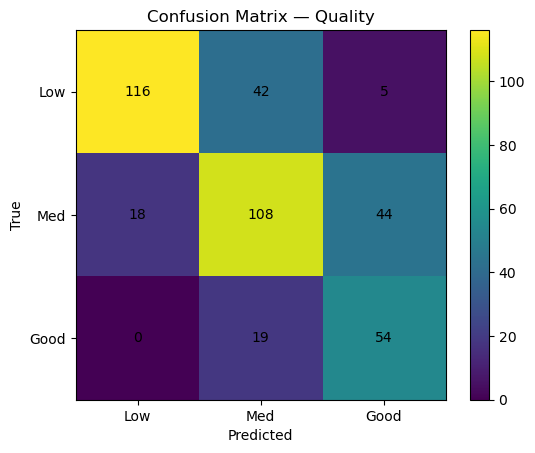

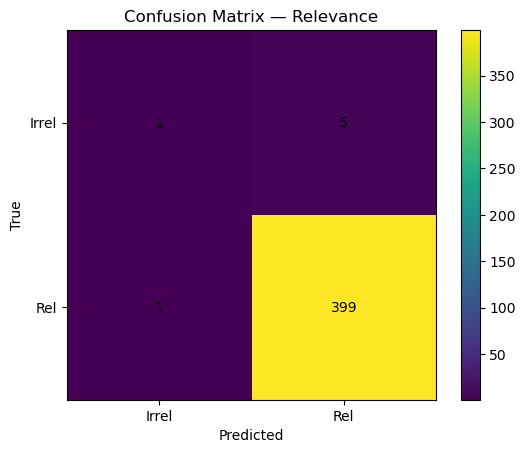

,reviewText,pred_quality,pred_relevance,uvs
1220,Okay Breakfast Spot with a Standout Dish\n\nHa...,Good,Relevant,0.692
236,"This hotel is very aesthetic, modern and has a...",Good,Relevant,0.690
4066,It was a great place; the most beautiful meatl...,Good,Relevant,0.690
3115,Truffle steamed buns are so delicious! The win...,Good,Relevant,0.687
2622,This is one of the classic tourist attractions...,Good,Relevant,0.687
2531,I have become a regular customer of this shop....,Good,Relevant,0.686
2623,The Hainanese chicken rice is absolutely delic...,Good,Relevant,0.686
129,Such an intimate and truly unique omakase expe...,Good,Relevant,0.686
2475,Attended Arsenal vs Newcastle match at this ma...,Good,Relevant,0.685
225,The Far East Organization Childrens Garden is ...,Good,Relevant,0.684


In [24]:
# Probabilities on validation set
q_probs, r_probs = predict_proba(model, tok, val_df["reviewText"].tolist(), cfg)
q_pred = q_probs.argmax(1)
r_pred = r_probs.argmax(1)

print("QUALITY (0=Low,1=Med,2=Good)")
print(classification_report(val_df["yq"], q_pred, digits=3))
print("\nRELEVANCE (0=Irrel,1=Rel)")
print(classification_report(val_df["yr"], r_pred, digits=3))

# Confusion matrices
cm_q = confusion_matrix(val_df["yq"], q_pred, labels=[0,1,2])
cm_r = confusion_matrix(val_df["yr"], r_pred, labels=[0,1])

# Plot CM: Quality
plt.figure()
plt.imshow(cm_q, interpolation="nearest")
plt.title("Confusion Matrix — Quality")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1,2], ["Low","Med","Good"])
plt.yticks([0,1,2], ["Low","Med","Good"])
for i in range(cm_q.shape[0]):
    for j in range(cm_q.shape[1]):
        plt.text(j, i, str(cm_q[i, j]), ha="center", va="center")
plt.colorbar()
plt.show()

# Plot CM: Relevance
plt.figure()
plt.imshow(cm_r, interpolation="nearest")
plt.title("Confusion Matrix — Relevance")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0,1], ["Irrel","Rel"])
plt.yticks([0,1], ["Irrel","Rel"])
for i in range(cm_r.shape[0]):
    for j in range(cm_r.shape[1]):
        plt.text(j, i, str(cm_r[i, j]), ha="center", va="center")
plt.colorbar()
plt.show()

# “Usefulness” score on val (for ranking)
UVS = r_probs[:,1] * (0.7*q_probs[:,2] + 0.3*q_probs[:,1])
val_view = val_df.assign(
    pred_quality=np.array(["Low","Medium","Good"])[q_pred],
    pred_relevance=np.array(["Irrelevant","Relevant"])[r_pred],
    uvs=np.round(UVS,3)
)
val_view.sort_values("uvs", ascending=False).head(10)[["reviewText","pred_quality","pred_relevance","uvs"]]
